In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) # makes the notebook fill the whole window

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import operator # Used for dictionary manipulation
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from scipy import stats

In [2]:
iris = pd.read_csv('./Iris.csv').drop(columns='Id')
iris

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica


In [3]:
def GNB(xi,uik,sik,yk):
    '''xi is the observed value
       uik is the mean of the class
       sik is the std of the class
       yk is the probability of that class'''
    # P(xi | yk) * yk
    return (1 / np.sqrt(2 * np.pi * (sik ** 2))) * np.exp((-1/2) * ((xi - uik)/(sik)) ** 2) * yk

def Gaussian_Naive_Bayes(train : pd.DataFrame, test : pd.DataFrame, target : str) -> list:
    '''Given a dataset and a target, generate a list of predictions based on Gaussian Naive Bayes
       train  : Pandas DataFrame with the data we want to generate means/stds for
       test   : Pandas DataFrame with the data we want to predict the target for
       target : String of the label from the data that we are looking to predict'''
    
    # Get the classes, labels, counts, means, and standard deviations from the training data
    classes = train[target].unique()
    labels = train.groupby(target).mean().loc[classes[0]].index
    cnts = train.groupby(target).count()
    means = train.groupby(target).mean()
    stds = train.groupby(target).std()
    
    # Start predicting
    predictions = []
    
    # Iterate over the testing data
    # Calculate the probability that the data point belongs to each class
    # This is done by using the Guassian Distribution function by comparing each label of the data point to the means/stds of each class
    # The highest value from this is the most likely class
    
    # For data point in testing data
    for index in range(len(test)):
        # Probabilities of each class
        probabilities = {}
        # Per class
        for cls in classes:
            probabilities[cls] = 1
            # Per label
            for label in labels:
                # Current value of the data point
                value = test.iloc[index][label]
                # Probability of being that class
                p_y = cnts.loc[cls][0]/len(train)
                # Mean of the current class
                mean = means.loc[cls][label]
                # Standard deviation of the current class
                std = stds.loc[cls][label]

                # Gaussian Naive Bayes on the value, mean, std, and p_y
                calc = GNB(value,mean,std,p_y)
                # Multiply current probability by the calculated probability
                probabilities[cls] *= calc
        # Get the prediction, which is the class with the highest probability
        prediction = max(probabilities.items(), key=operator.itemgetter(1))[0]
        predictions.append(prediction)
    return predictions

In [4]:
train,test = train_test_split(iris,test_size=.2)

target = 'Species'
predictions = Gaussian_Naive_Bayes(train,test,target)
accuracy = np.sum(test[target] == predictions) / len(test) * 100

# Using library
gnb = GaussianNB()
gnb.fit(train.drop(columns=target),train[target])

gnb_predictions = gnb.predict(test.drop(columns=target))
accuracy_gnb = np.sum(test[target] == gnb_predictions) / len(test) * 100

print(f"My accuracy: {accuracy:.2f}%\nLibrary Accuracy: {accuracy_gnb:.2f}%")

My accuracy: 96.67%
Library Accuracy: 96.67%


In [5]:
# Check for missing values
display(iris.isna().any())

# Check for duplicates
iris_no_duplicates = iris.drop_duplicates()
num_duplicates = len(iris) - len(iris_no_duplicates)
print(f"There {'are' if num_duplicates != 0 else 'is'} {num_duplicates} duplicate rows")

SepalLengthCm    False
SepalWidthCm     False
PetalLengthCm    False
PetalWidthCm     False
Species          False
dtype: bool

There are 3 duplicate rows


In [29]:
# Run GNB on no duplicate data
train,test = train_test_split(iris_no_duplicates,test_size=.2)

target = 'Species'
predictions = Gaussian_Naive_Bayes(train,test,target)
accuracy = np.sum(test[target] == predictions) / len(test) * 100

# Using library
gnb = GaussianNB()
gnb.fit(train.drop(columns=target),train[target])

gnb_predictions = gnb.predict(test.drop(columns=target))
accuracy_gnb = np.sum(test[target] == gnb_predictions) / len(test) * 100

print(f"My accuracy: {accuracy:.2f}%\nLibrary Accuracy: {accuracy_gnb:.2f}%")

My accuracy: 96.67%
Library Accuracy: 96.67%


In [7]:
# Look at the data for statistical anomalies
display(iris.describe())

remove_indices = []
for col in iris.drop(columns=target).columns:
    # Calculate z scores
    z = np.abs(stats.zscore(iris[col]))
    # Populate list with z scores above 3
    above_3_z = np.where(z > 3)
    remove_indices += list(above_3_z[0])

# Remove indices that are outliers
remove_indices = np.unique(np.array(remove_indices))
trimmed = iris.drop(remove_indices)

print(f"Dropped {len(remove_indices)} outlier{'s' if len(remove_indices) > 1 else ''}")

# Run GNB on no outliers
train,test = train_test_split(trimmed,test_size=.2)

target = 'Species'
predictions = Gaussian_Naive_Bayes(train,test,target)
accuracy = np.sum(test[target] == predictions) / len(test) * 100

# Using library
gnb = GaussianNB()
gnb.fit(train.drop(columns=target),train[target])

gnb_predictions = gnb.predict(test.drop(columns=target))
accuracy_gnb = np.sum(test[target] == gnb_predictions) / len(test) * 100

print(f"My accuracy: {accuracy:.2f}%\nLibrary Accuracy: {accuracy_gnb:.2f}%")

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


Dropped 1 outlier
My accuracy: 93.33%
Library Accuracy: 93.33%


In [30]:
# Checking different testing/training sizes
# Run GNB on no outliers
for ts in np.arange(.1,1,.1):
    train,test = train_test_split(iris,test_size=ts)

    target = 'Species'
    predictions = Gaussian_Naive_Bayes(train,test,target)
    accuracy = np.sum(test[target] == predictions) / len(test) * 100

    # Using library
    gnb = GaussianNB()
    gnb.fit(train.drop(columns=target),train[target])

    gnb_predictions = gnb.predict(test.drop(columns=target))
    accuracy_gnb = np.sum(test[target] == gnb_predictions) / len(test) * 100
    print(f"Accuracies for testing size {ts * 100 : .2f}%:")
    print(f"My accuracy: {accuracy:.2f}%\nLibrary Accuracy: {accuracy_gnb:.2f}%\n")

Accuracies for testing size  10.00%:
My accuracy: 93.33%
Library Accuracy: 93.33%

Accuracies for testing size  20.00%:
My accuracy: 90.00%
Library Accuracy: 90.00%

Accuracies for testing size  30.00%:
My accuracy: 93.48%
Library Accuracy: 93.48%

Accuracies for testing size  40.00%:
My accuracy: 90.00%
Library Accuracy: 91.67%

Accuracies for testing size  50.00%:
My accuracy: 96.00%
Library Accuracy: 96.00%

Accuracies for testing size  60.00%:
My accuracy: 92.22%
Library Accuracy: 92.22%

Accuracies for testing size  70.00%:
My accuracy: 92.45%
Library Accuracy: 93.40%

Accuracies for testing size  80.00%:
My accuracy: 84.17%
Library Accuracy: 85.00%

Accuracies for testing size  90.00%:
My accuracy: 85.93%
Library Accuracy: 85.19%



C:\Users\bvano\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\bvano\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:307: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
C:\Users\bvano\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\tools.py:313: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.rowNum + 1, ax.colNum]:
C:\Users\bvano\Anaconda3\lib\site-packages\pandas\plotting\_matpl

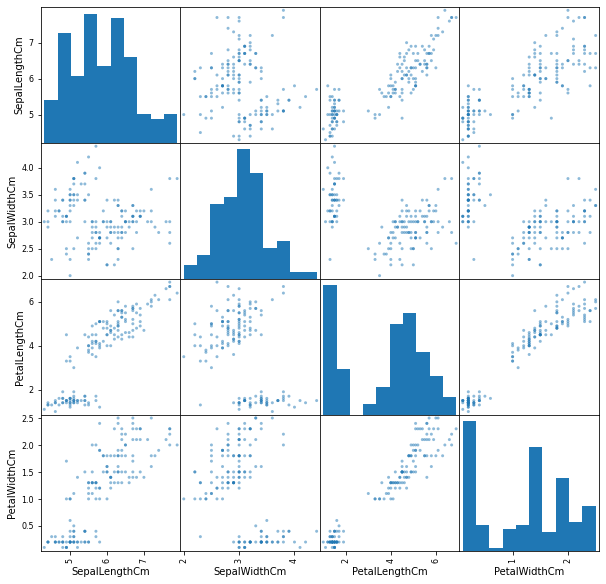

In [12]:
pd.plotting.scatter_matrix(iris,figsize=(10,10))
plt.show()